# COVID-19 
(Previously known as nCoV-2019)
<img src='https://ars.els-cdn.com/content/image/3-s2.0-B9780443073670000409-f040-001-9780443073670.jpg'>

<b>Overview:</b> <br>
Tracking the COVID-19 viral infections around the world.

<b>Data Source:</b> <br>
Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) <br>
https://github.com/CSSEGISandData/COVID-19 <br>
The Lancet <br>
https://www.thelancet.com/pb-assets/Lancet/pdfs/S0140673620302117.pdf <br>
Clinical outcome (99 Cases)
<li> Remained in hospital 57 (58%)
<li> Discharged 31 (31%)
<li> Died 11 (11%)
<br>
JAMA (The Journal of the American Medical Association)<br>    
https://jamanetwork.com/journals/jama/fullarticle/2761044 <br>
<li>In this single-center case series of 138 hospitalized patients with confirmed NCIP in Wuhan, China, presumed hospital-related transmission of 2019-nCoV was suspected in 41% of patients, 26% of patients received ICU care, and mortality was 4.3%.

Generated on: 2020-03-10 21:27




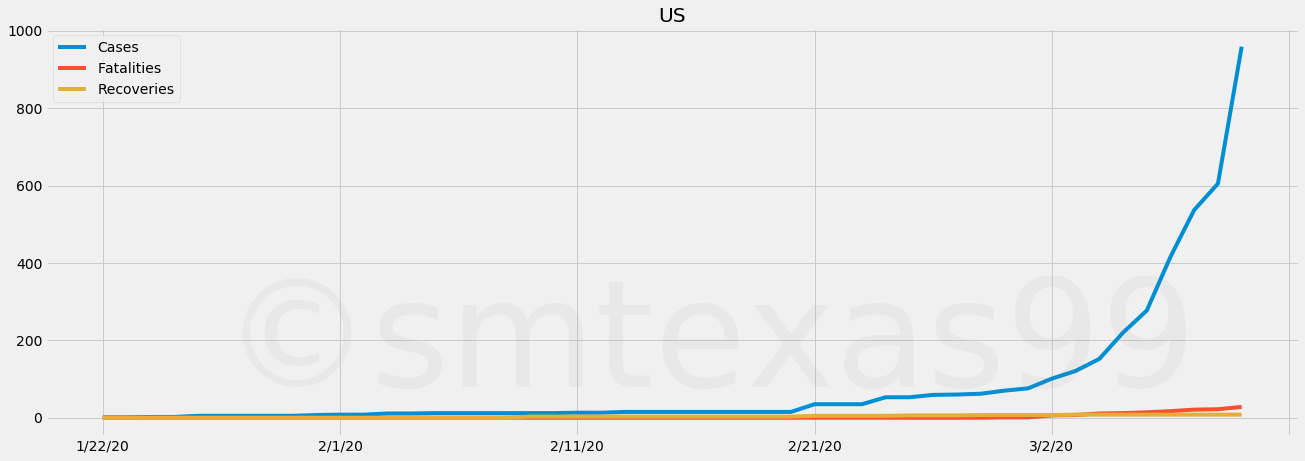

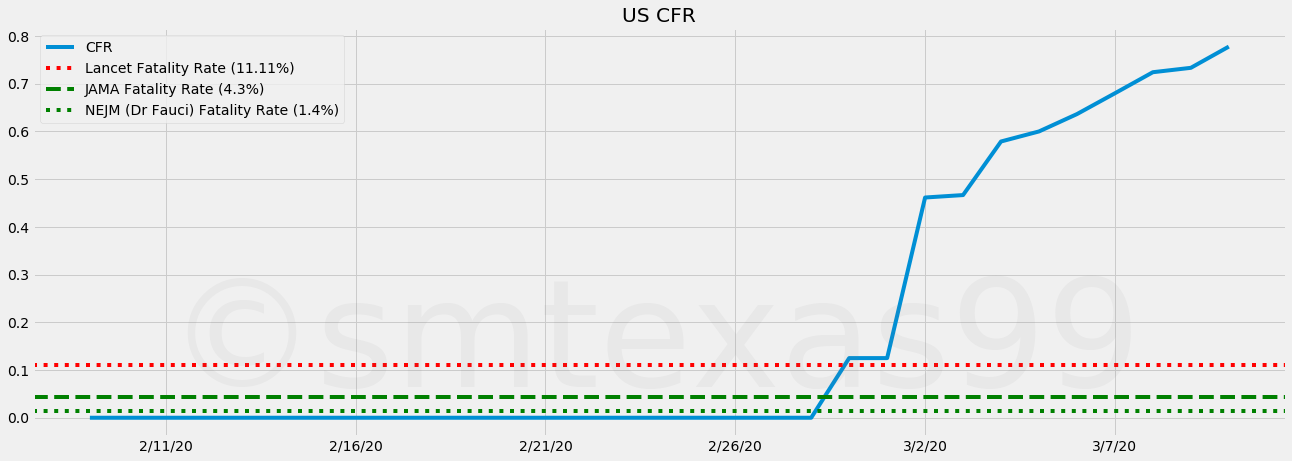

US CASES    ( Generated on: 2020-03-10 21:27 )
************************************************
a =  13.43798216930037
b =  0.32287602175909963
c =  36.50978011333185
R^2 = 0.9894
Next predicted data point   1,271
         7 Days from Now    11,868
        14 Days from Now    113,429
        21 Days from Now    1,086,834
        28 Days from Now    10,416,291
        30 Days from Now    19,868,219


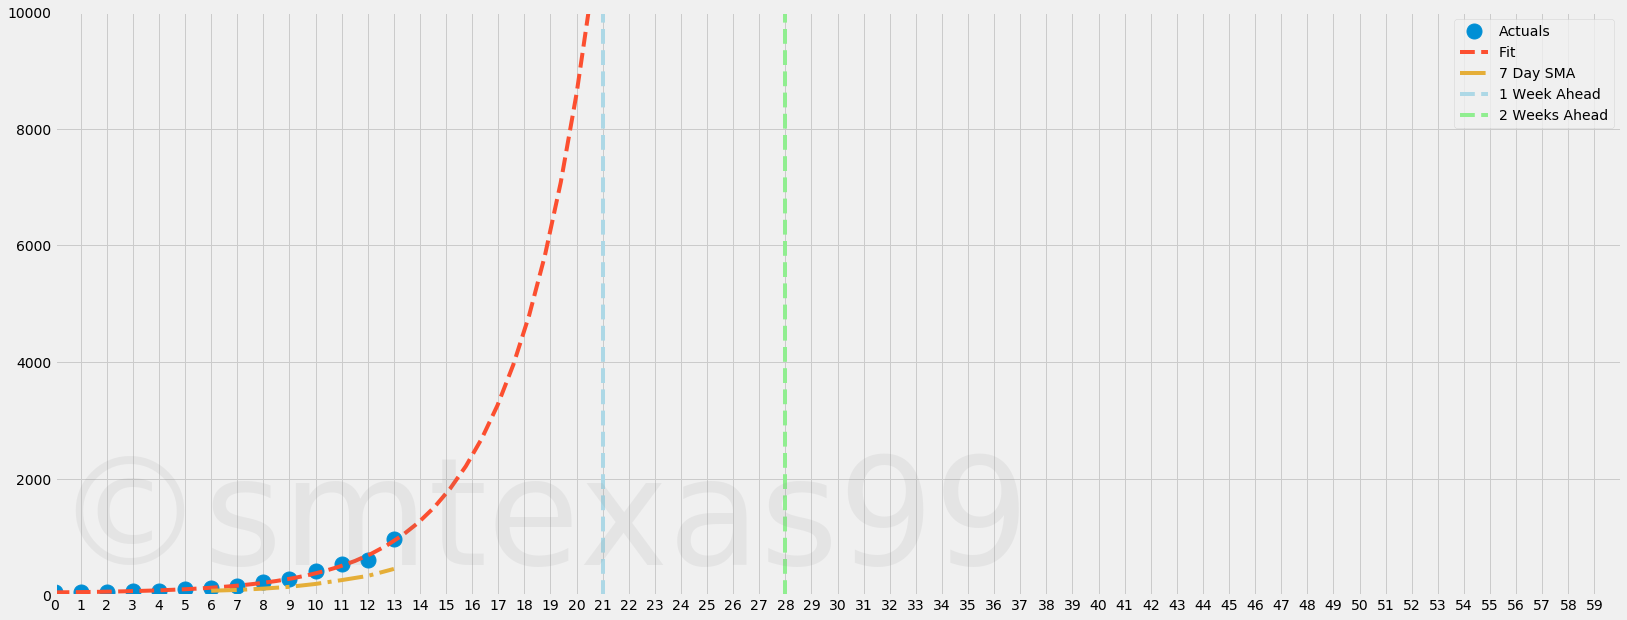

US FATALITIES    ( Generated on: 2020-03-10 21:27 )
**************************************************************
a =  9.774959694325437
b =  0.10624837842112825
c =  -11.338582201786203
R^2 = 0.9835
Next predicted data point   32
         7 Days from Now    80
        14 Days from Now    180
        21 Days from Now    391
        28 Days from Now    836
        30 Days from Now    1,037


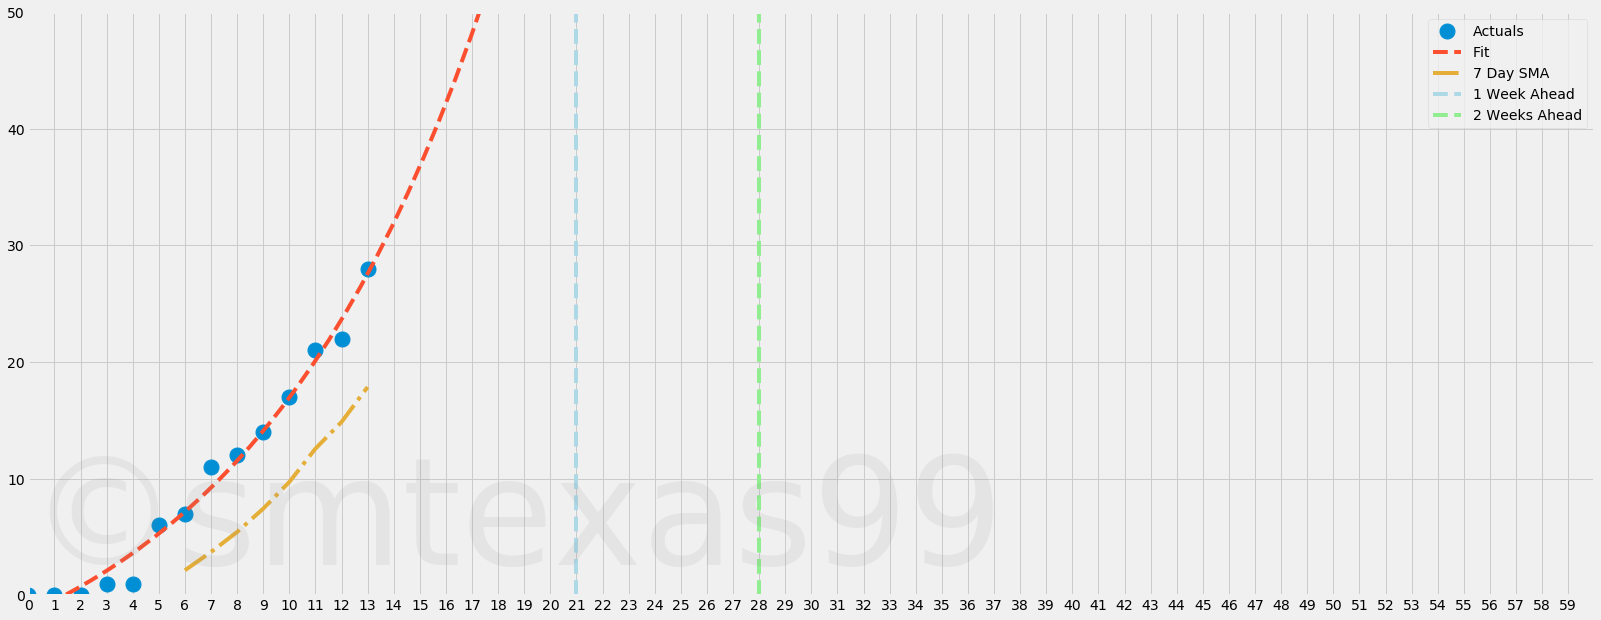



Global
------
Cases:       118,582
Recoveries:  64,404
Fatalities:   4,262
Remaining:   49,916
In ICU:       5,491


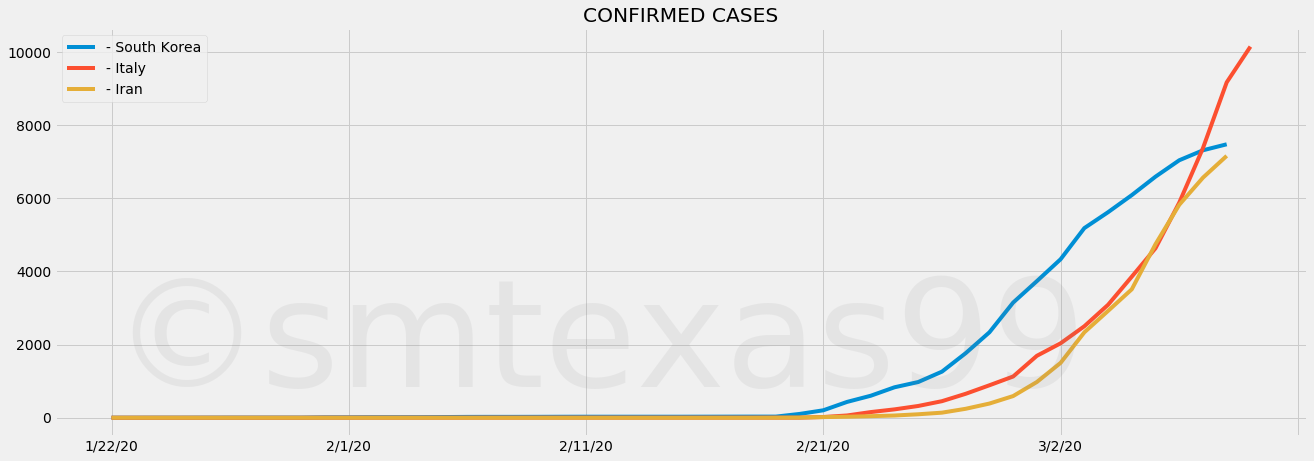

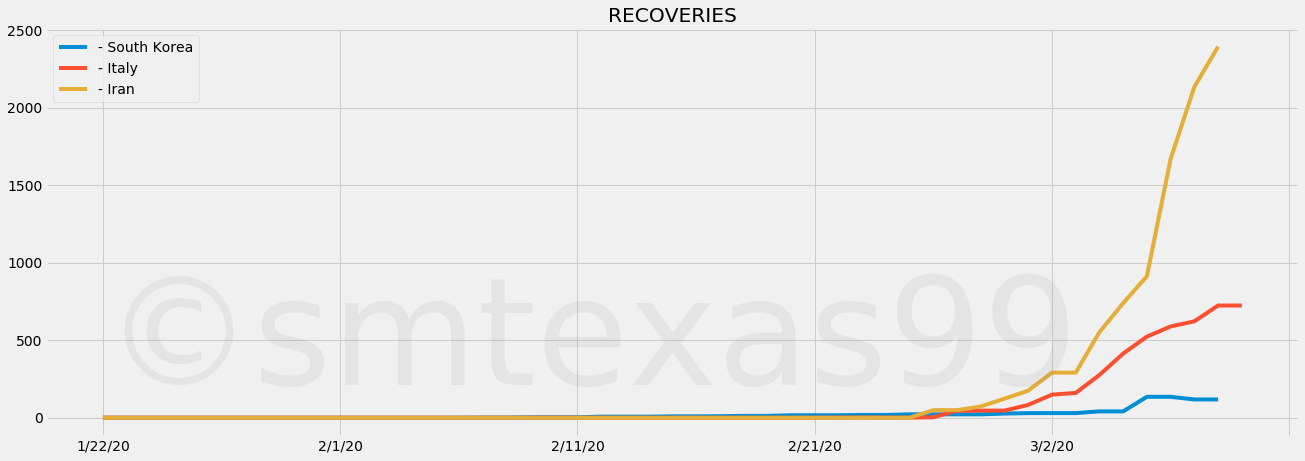

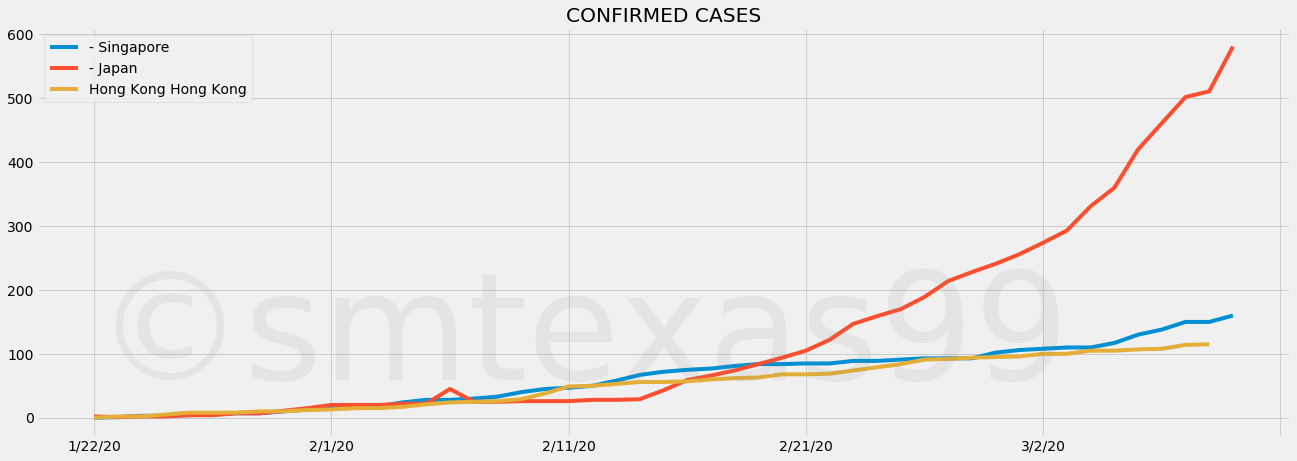

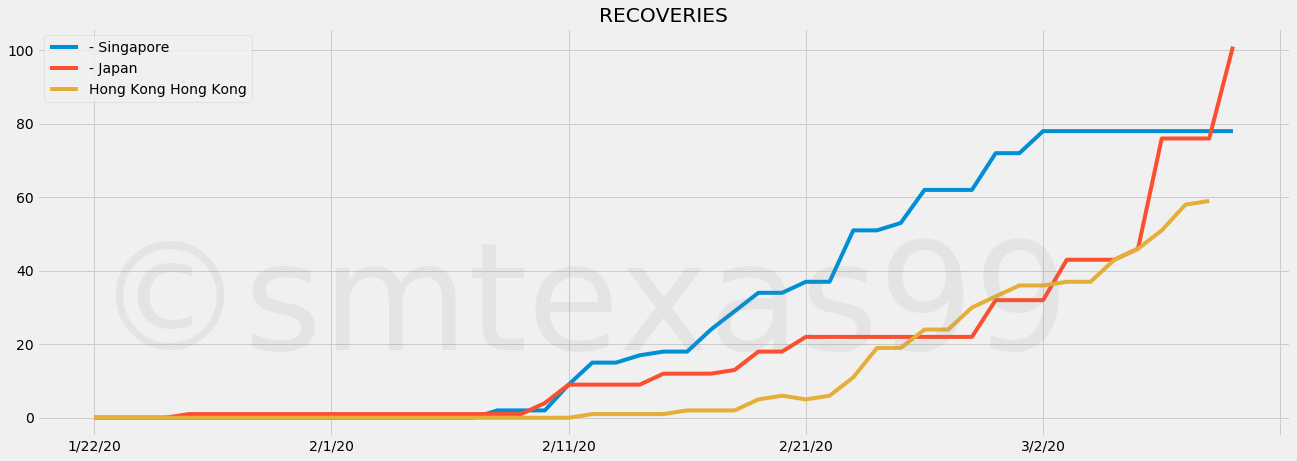

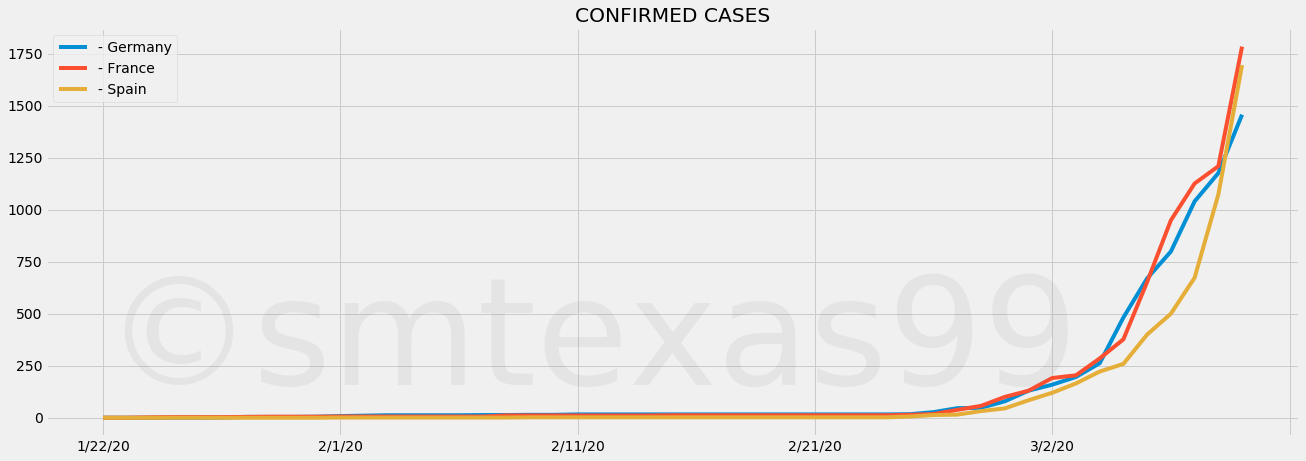

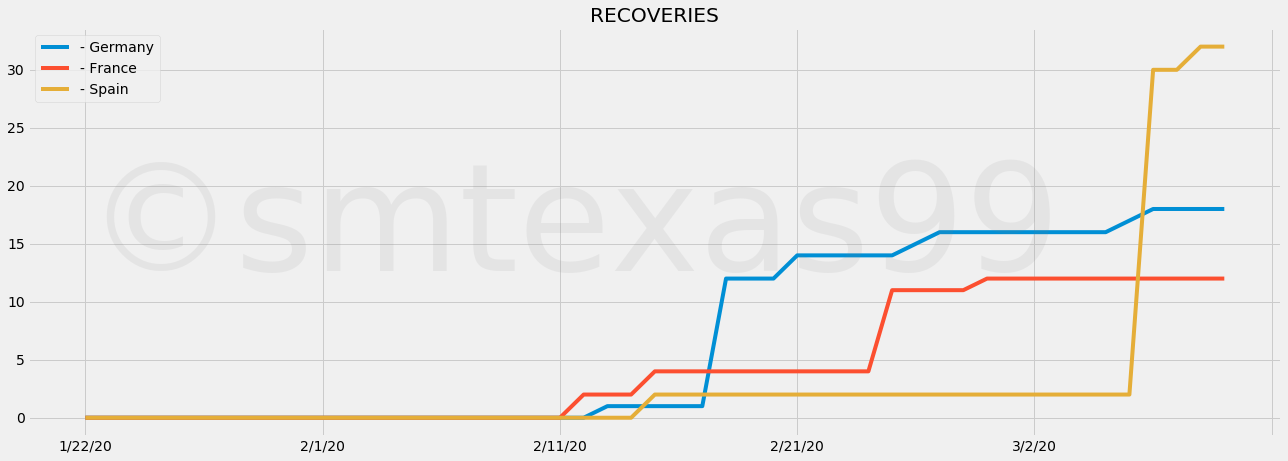

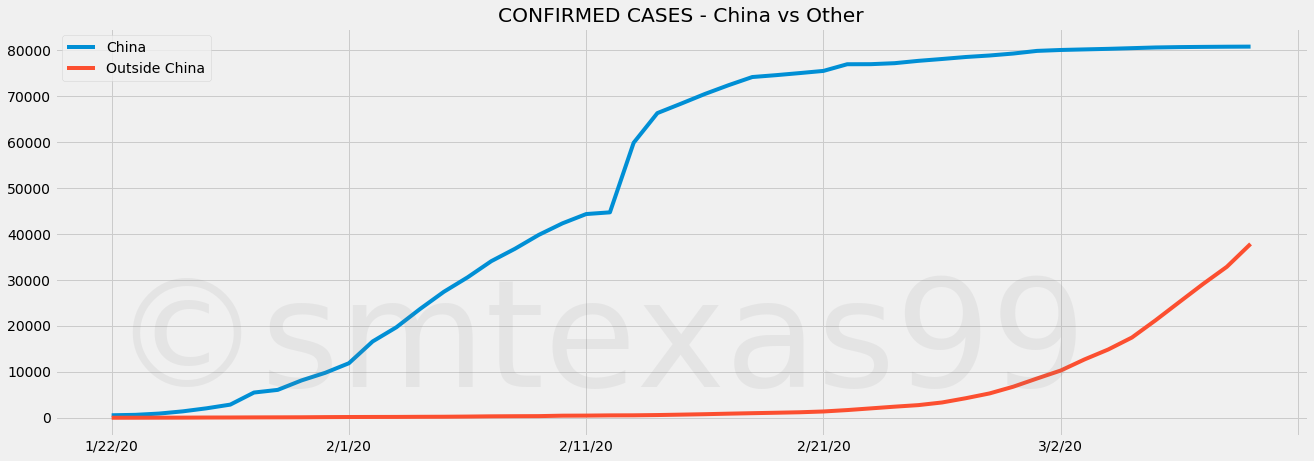

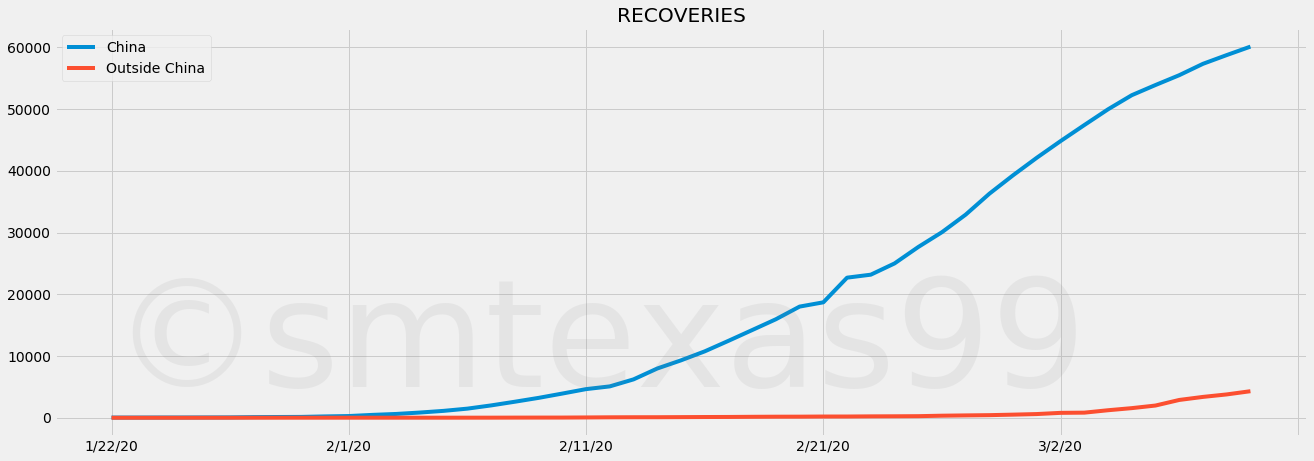

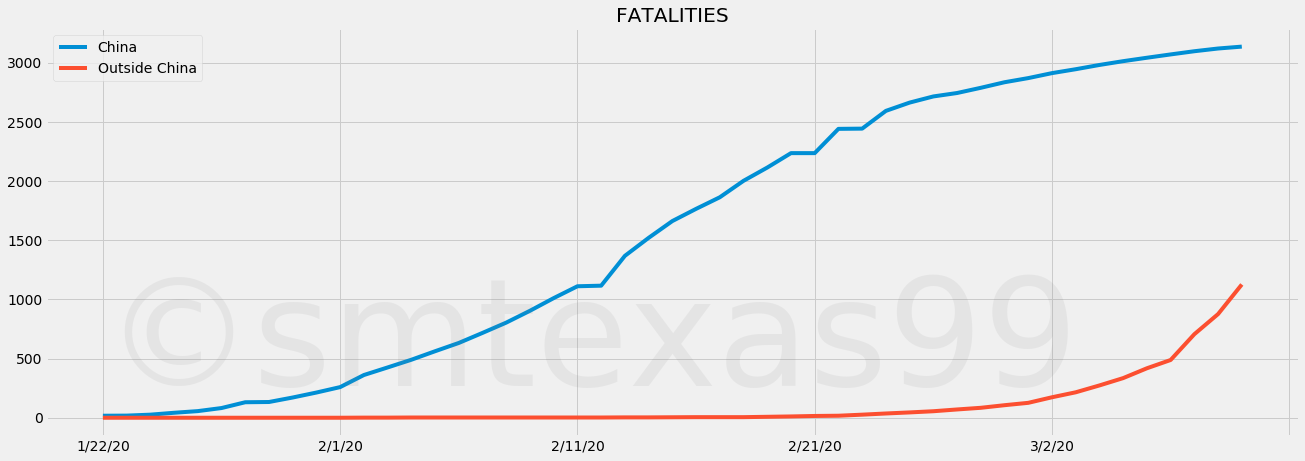

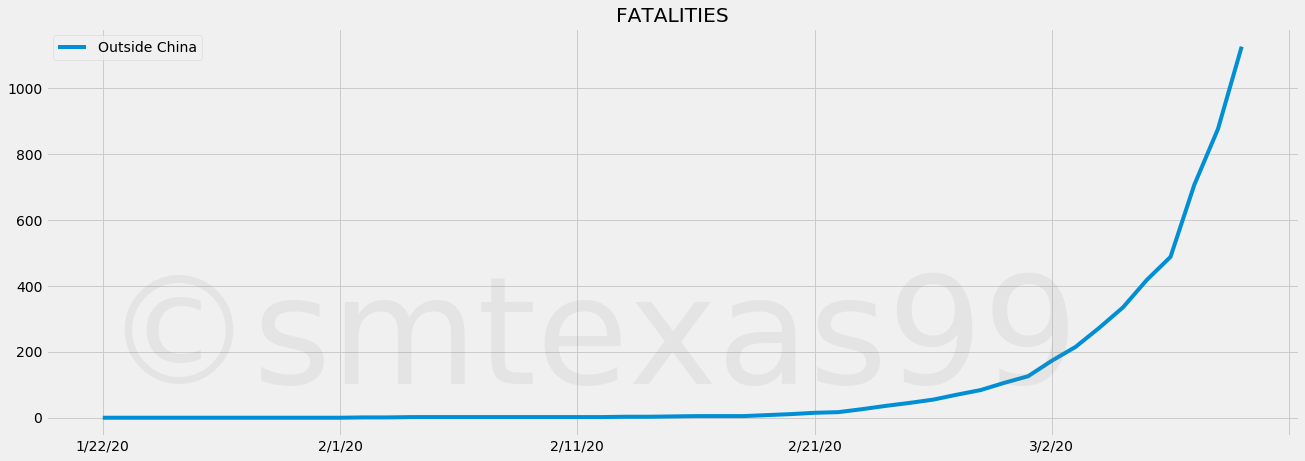

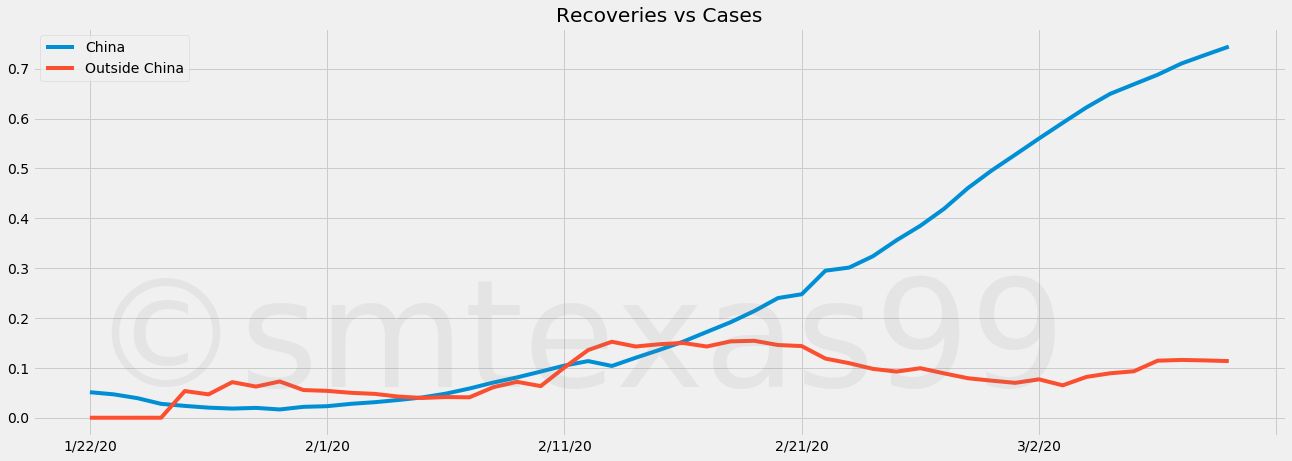

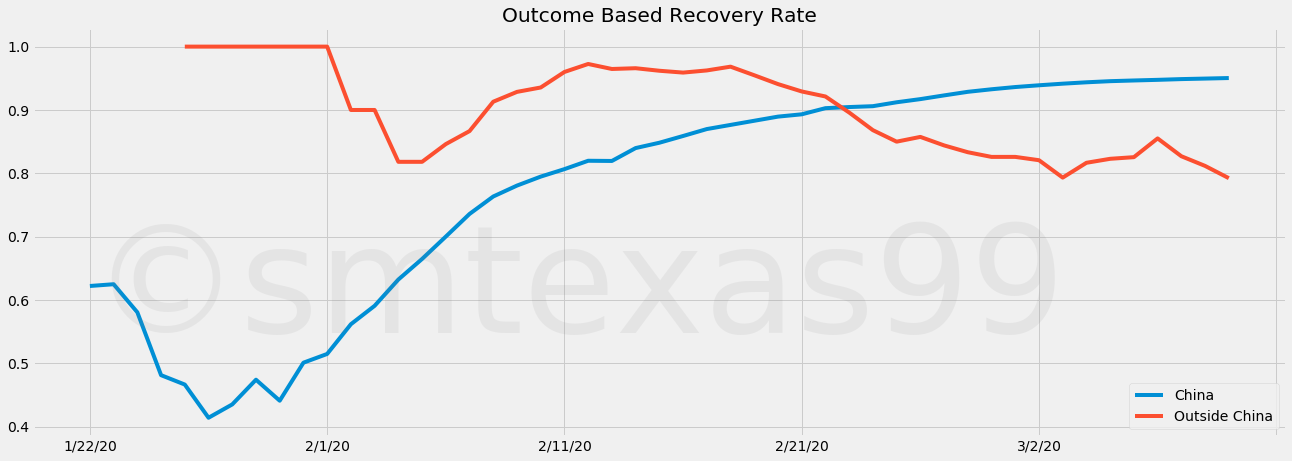

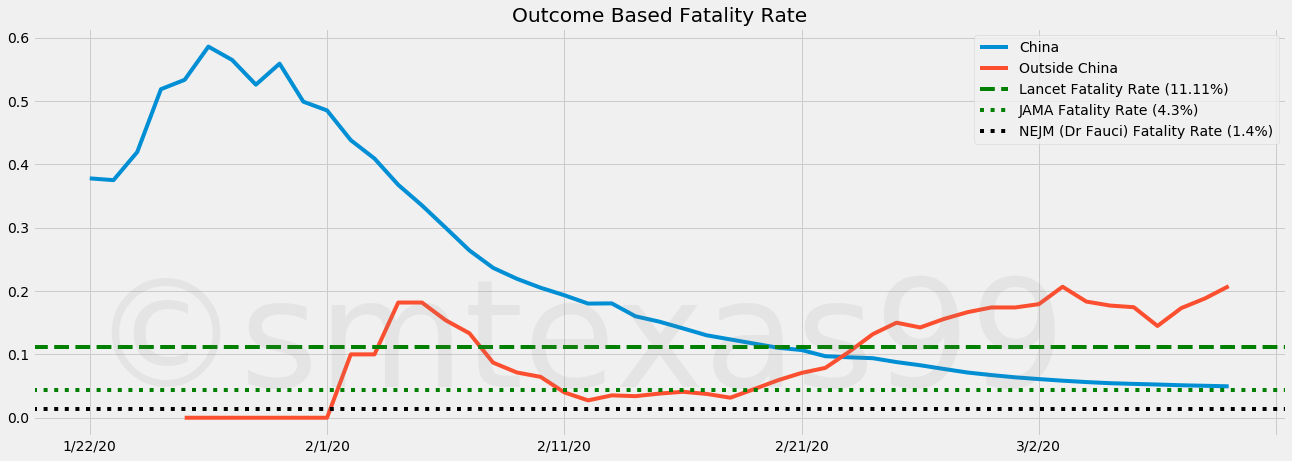

*********************************************************
Processing Time:                       0:00:04.355707
*********************************************************


In [1]:
%run smtexas99_covid19.py

Reference Rates: https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates